In [36]:
import pandas as pd
import pymysql
from matplotlib import pyplot as plt
import numpy as np
import yaml
from os import path
import re
from sqlalchemy import create_engine

with open('../config.yml') as f:
    config = yaml.load(f)

project_dir = config['PROJECT']
project_db_dir = config['DATABASE']
con = pymysql.connect(host=config['MYSQL_HOST'], user=config['MYSQL_USER'], passwd=config['MYSQL_PASSWD'], 
                      db=config['MYSQL_DB'])
cur = con.cursor()
engine = create_engine("mysql+pymysql://{user}:{pw}@{server}/{db}"
                       .format(server=config['MYSQL_HOST'], user=config['MYSQL_USER'], pw=config['MYSQL_PASSWD'], 
                               db=config['MYSQL_DB']))

In [151]:
!bash -c "../scripts/dbsnp.sh"


Can't locate Bio/EnsEMBL/Registry.pm in @INC (you may need to install the Bio::EnsEMBL::Registry module) (@INC contains: /home/kaplanlab/vep/modules /home/kaplanlab/vep /opt/CilioGenics/domain/PfamScan /home/kaplanlab/perl5/lib/perl5/5.26.1/x86_64-linux-gnu-thread-multi /home/kaplanlab/perl5/lib/perl5/5.26.1 /home/kaplanlab/perl5/lib/perl5/x86_64-linux-gnu-thread-multi /home/kaplanlab/perl5/lib/perl5 /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.26.1 /usr/local/share/perl/5.26.1 /usr/lib/x86_64-linux-gnu/perl5/5.26 /usr/share/perl5 /usr/lib/x86_64-linux-gnu/perl/5.26 /usr/share/perl/5.26 /home/kaplanlab/perl5/lib/perl5/5.26.0 /home/kaplanlab/perl5/lib/perl5/5.26.0/x86_64-linux-gnu-thread-multi /usr/local/lib/site_perl /usr/lib/x86_64-linux-gnu/perl-base) at /home/kaplanlab/vep/modules/Bio/EnsEMBL/VEP/BaseVEP.pm line 58.
BEGIN failed--compilation aborted at /home/kaplanlab/vep/modules/Bio/EnsEMBL/VEP/BaseVEP.pm line 58.
Compilation failed in require at /usr/share/perl/5.26/base.pm l

In [18]:
df = pd.read_csv(path.join(project_dir, 'dbSNP', 'result2017_only_hgvsp.tsv'), sep='\t')
df.loc[:, 'HGVSp'] = df['Extra'].apply(lambda x: re.sub(r'^(.*?)HGVSp=(.*?)(;|$)(.*?)', r'\2', x).replace('%3D', '='))
df.loc[:, 'Impact'] = df['Extra'].apply(lambda x: '' if 'IMPACT' not in x else
                                        re.sub(r'^(.*?)IMPACT=([^;]+)(.*?)$', r'\2', x))
df.drop(['Amino_acids', 'Codons', 'Existing_variation', 'Extra'], axis=1, inplace=True)

In [19]:
cur.execute('TRUNCATE TABLE dbsnp')
con.commit()
df.to_sql('dbsnp', engine, if_exists='append', index=True)

OperationalError: (2006, "MySQL server has gone away (BrokenPipeError(32, 'Broken pipe'))")

In [67]:
def create_count_by_consequence(df, other_lim=10, delim=','):
    consequence_dict = {}
    for values in df['Consequence'].tolist():
        for val in values.split(delim):
            val = val.strip()
            if val not in consequence_dict:
                consequence_dict[val] = 0
            consequence_dict[val]+=1
    consequence_tuple = {'indices': [], 'counts': []}
    for val, count in consequence_dict.items():
        consequence_tuple['indices'].append(val.replace('_', ' ').capitalize())
        consequence_tuple['counts'].append(count)
        
    
    count_by_consequence = pd.Series(consequence_tuple['counts'], index=consequence_tuple['indices'])
    
    count_by_consequence = count_by_consequence.sort_values()
    if count_by_consequence.shape[0] > other_lim:
        count_by_consequence = count_by_consequence.groupby(np.where(count_by_consequence<=count_by_consequence.iloc[other_lim],
                                                                     'Others', count_by_consequence.index)).sum()#.plot.pie()

    return count_by_consequence


In [2]:
df_dbsnp = pd.read_sql("""SELECT Consequence FROM dbsnp""", con)

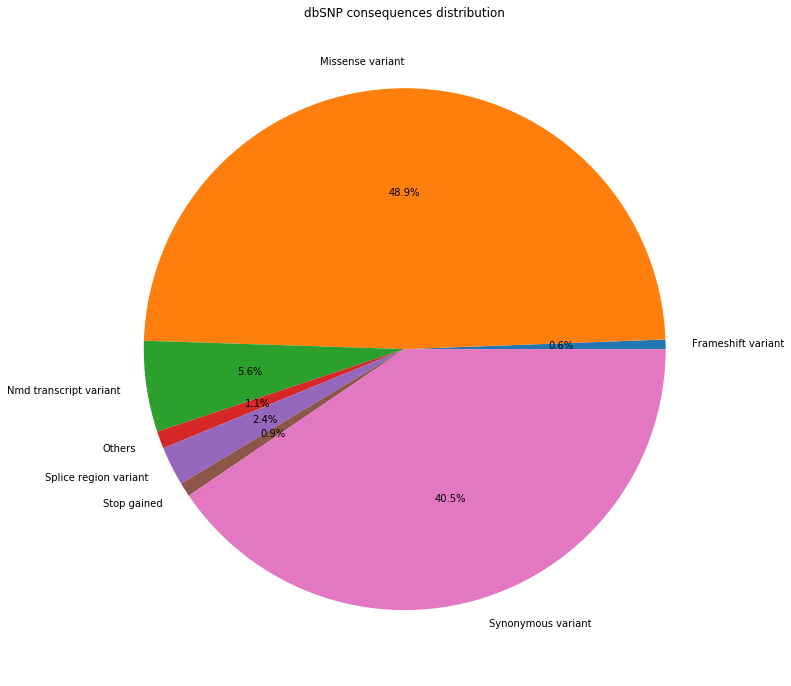

In [74]:
plt.rcParams['figure.figsize'] = [12, 12]

count_by_consequence = create_count_by_consequence(df_dbsnp, 12)
plt.title('dbSNP consequences distribution')
count_by_consequence.plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.savefig(path.join(project_dir, 'figures', 'pie_chart_dbsnp_consequence.png'))
plt.show()

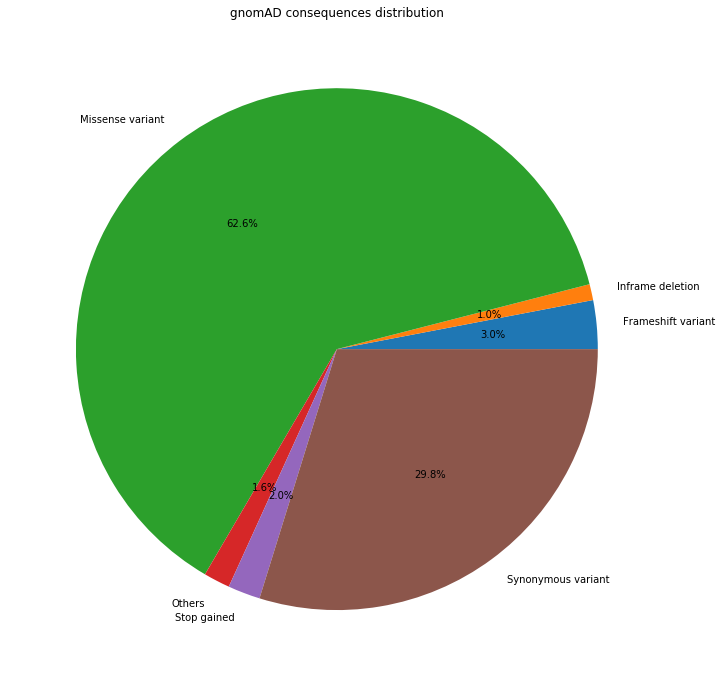

In [75]:
df_gnomad = pd.read_sql("""SELECT consequence as Consequence FROM gnomad""", con)
count_by_consequence = create_count_by_consequence(df_gnomad, 11)
plt.title('gnomAD consequences distribution')
count_by_consequence.plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.savefig(path.join(project_dir, 'figures', 'pie_chart_gnomad_consequence.png'))
plt.show()

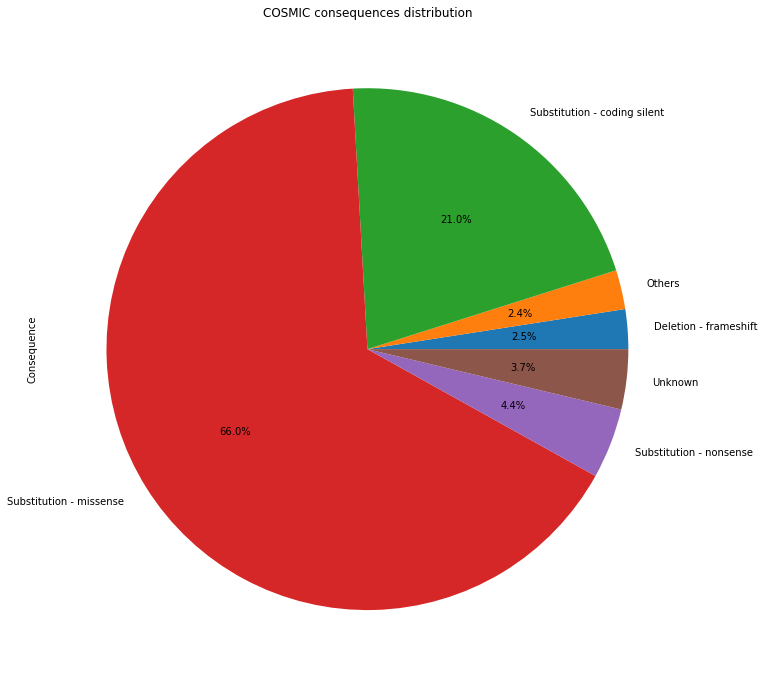

In [76]:
df_cosmic = pd.read_sql("""SELECT mutation_description as Consequence FROM CosmicMutantExport""", con)

count_by_consequence = create_count_by_consequence(df_cosmic)
plt.title('COSMIC consequences distribution')
count_by_consequence.plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('Consequence')
plt.savefig(path.join(project_dir, 'figures', 'pie_chart_cosmic_consequence.png'))
plt.show()